In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from empiricaldist import Pmf, Cdf
from matplotlib.ticker import MaxNLocator
%matplotlib inline  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [97]:
train_data = pd.read_csv("train.csv")

In [98]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [99]:
# imputing missing data as in baseline model

train_data["LotFrontage"] = train_data["LotFrontage"].fillna(train_data["LotFrontage"].median())
train_data["MasVnrArea"] = train_data["MasVnrArea"].fillna(train_data["MasVnrArea"].median())

train_data["MasVnrType"] = train_data["MasVnrType"].fillna(train_data["MasVnrType"].mode())
train_data["Electrical"] = train_data["Electrical"].fillna(train_data["Electrical"].mode())

cat_cols= [x for x in train_data.columns if train_data[x].dtype==np.object]
train_data[cat_cols]=train_data[cat_cols].fillna("NA")
train_data.drop("GarageYrBlt", axis=1, inplace=True)

In [100]:
# transforming some features as in baseline model

train_data[["MoSold", "MSSubClass"]] = train_data[["MoSold", "MSSubClass"]].astype(str)

In [101]:
# Adding two additional engineered features:
#1.Remod: binary feature, 1 if property was remodeled and 0 otherwise
#2.Remod_YrsElapsed: int, number of years since last remodeling refrenced from year of purchase

train_data["Remod"]=0
train_data.loc[train_data["YearBuilt"]!=train_data["YearRemodAdd"], "Remod"]=1
train_data["Remod"].value_counts()/len(train_data)

0    0.523288
1    0.476712
Name: Remod, dtype: float64

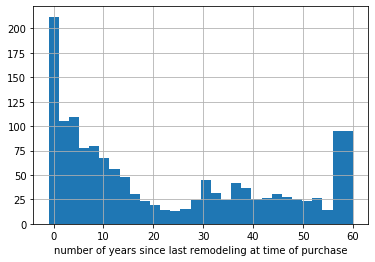

In [102]:
train_data["Remod_YrsElapsed"] = train_data["YrSold"]-train_data["YearRemodAdd"]
train_data["Remod_YrsElapsed"].hist(bins=30)
plt.xlabel("number of years since last remodeling at time of purchase");

In [103]:
# cardinality of each categorical feature 

for column in cat_cols:
    print('Number of categories in the variable {}: {}'.format(column,len(train_data[column].unique())))


Number of categories in the variable MSZoning: 5
Number of categories in the variable Street: 2
Number of categories in the variable Alley: 3
Number of categories in the variable LotShape: 4
Number of categories in the variable LandContour: 4
Number of categories in the variable Utilities: 2
Number of categories in the variable LotConfig: 5
Number of categories in the variable LandSlope: 3
Number of categories in the variable Neighborhood: 25
Number of categories in the variable Condition1: 9
Number of categories in the variable Condition2: 8
Number of categories in the variable BldgType: 5
Number of categories in the variable HouseStyle: 8
Number of categories in the variable RoofStyle: 6
Number of categories in the variable RoofMatl: 8
Number of categories in the variable Exterior1st: 15
Number of categories in the variable Exterior2nd: 16
Number of categories in the variable MasVnrType: 5
Number of categories in the variable ExterQual: 4
Number of categories in the variable ExterCon

In [104]:
# Rare labels encoder

rare_encoder = RareLabelCategoricalEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=2, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=cat_cols # apply to all categorical columns
) 

rare_encoder.fit(train_data)
train_data = rare_encoder.transform(train_data)

In [105]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Id                  1460 non-null int64
MSSubClass          1460 non-null object
MSZoning            1460 non-null object
LotFrontage         1460 non-null float64
LotArea             1460 non-null int64
Street              1460 non-null object
Alley               1460 non-null object
LotShape            1460 non-null object
LandContour         1460 non-null object
Utilities           1460 non-null object
LotConfig           1460 non-null object
LandSlope           1460 non-null object
Neighborhood        1460 non-null object
Condition1          1460 non-null object
Condition2          1460 non-null object
BldgType            1460 non-null object
HouseStyle          1460 non-null object
OverallQual         1460 non-null int64
OverallCond         1460 non-null int64
YearBuilt           1460 non-null int64
YearRemodAdd        1460 non-null int64
RoofStyle           1460 non-null obj

In [106]:
# which labels were kept in each cat variable ?

rare_encoder.encoder_dict_

{'MSZoning': Index(['RL', 'RM'], dtype='object'),
 'Street': array(['Pave', 'Grvl'], dtype=object),
 'Alley': Index(['NA'], dtype='object'),
 'LotShape': Index(['Reg', 'IR1'], dtype='object'),
 'LandContour': Index(['Lvl'], dtype='object'),
 'Utilities': array(['AllPub', 'NoSeWa'], dtype=object),
 'LotConfig': Index(['Inside', 'Corner'], dtype='object'),
 'LandSlope': Index(['Gtl'], dtype='object'),
 'Neighborhood': Index(['NAmes', 'CollgCr'], dtype='object'),
 'Condition1': Index(['Norm'], dtype='object'),
 'Condition2': Index(['Norm'], dtype='object'),
 'BldgType': Index(['1Fam'], dtype='object'),
 'HouseStyle': Index(['1Story', '2Story', '1.5Fin'], dtype='object'),
 'RoofStyle': Index(['Gable', 'Hip'], dtype='object'),
 'RoofMatl': Index(['CompShg'], dtype='object'),
 'Exterior1st': Index(['VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng'], dtype='object'),
 'Exterior2nd': Index(['VinylSd', 'MetalSd', 'HdBoard', 'Wd Sdng'], dtype='object'),
 'MasVnrType': Index(['None', 'BrkFace'], dtype='

In [107]:
# consequently the cardinality for cat vars with more than 3 labels changed/reduced
# cardinality of each categorical feature 

for column in cat_cols:
    print('Number of categories in the variable {}: {}'.format(column,len(train_data[column].unique())))


Number of categories in the variable MSZoning: 3
Number of categories in the variable Street: 2
Number of categories in the variable Alley: 2
Number of categories in the variable LotShape: 3
Number of categories in the variable LandContour: 2
Number of categories in the variable Utilities: 2
Number of categories in the variable LotConfig: 3
Number of categories in the variable LandSlope: 2
Number of categories in the variable Neighborhood: 3
Number of categories in the variable Condition1: 2
Number of categories in the variable Condition2: 2
Number of categories in the variable BldgType: 2
Number of categories in the variable HouseStyle: 4
Number of categories in the variable RoofStyle: 3
Number of categories in the variable RoofMatl: 2
Number of categories in the variable Exterior1st: 5
Number of categories in the variable Exterior2nd: 5
Number of categories in the variable MasVnrType: 3
Number of categories in the variable ExterQual: 3
Number of categories in the variable ExterCond: 

In [108]:
# now encode the cat vars using hot one encoding

ohe_enc = OneHotCategoricalEncoder(
    top_categories=None,
    drop_last=False) # automatically detects all cat vars in data

ohe_enc.fit(train_data)

train_data = ohe_enc.transform(train_data)

In [109]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 182 entries, Id to SaleCondition_Rare
dtypes: float64(2), int64(180)
memory usage: 2.0 MB


In [110]:
# evaluating model

X = train_data.drop(["Id", "SalePrice"], axis=1)
y = train_data["SalePrice"]

In [111]:
lightgbm_regr = LGBMRegressor()
scores = cross_val_score(lightgbm_regr, X, y, cv=5, scoring='neg_mean_squared_log_error')
scores = np.sqrt(np.abs(scores))
print("RMSLE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSLE: 0.14 (+/- 0.02)


In [112]:
print(scores)

[0.12523947 0.15230335 0.13601545 0.13209615 0.14225064]


In [113]:
rf_regr = RandomForestRegressor()
scores = cross_val_score(rf_regr, X, y, cv=5, scoring='neg_mean_squared_log_error')
scores = np.sqrt(np.abs(scores))
print("RMSLE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSLE: 0.15 (+/- 0.02)


In [114]:
print(scores)

[0.13766688 0.15691371 0.14410928 0.13994047 0.15634156]


In [115]:
# tune the lamda_l1 value 

lambdas=[1e-3, 1e-2, 0.1, 1.0, 10, 100]

for lambda_value in lambdas:
    lightgbm_regr = LGBMRegressor(lambda_l2=lambda_value)    
    scores = cross_val_score(lightgbm_regr, X, y, cv=5, scoring='neg_mean_squared_log_error')
    scores = np.sqrt(np.abs(scores))
    print(lightgbm_regr)
    print("For lambda = {}".format(lambda_value))
    print("RMSLE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', lambda_l2=0.001, learning_rate=0.1,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
For lambda = 0.001
RMSLE: 0.14 (+/- 0.02)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', lambda_l2=0.01, learning_rate=0.1,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample

In [116]:

depth_list = np.arange(1,20,step=2).tolist()


for depth_value in depth_list:
    
    rf_regr = RandomForestRegressor(max_depth=depth_value)
    scores = cross_val_score(rf_regr, X, y, cv=5, scoring='neg_mean_squared_log_error')
    scores = np.sqrt(np.abs(scores))
    print("For Tree max depth = {}".format(depth_value))
    print("RMSLE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


For Tree max depth = 1
RMSLE: 0.30 (+/- 0.03)
For Tree max depth = 3
RMSLE: 0.22 (+/- 0.01)
For Tree max depth = 5
RMSLE: 0.17 (+/- 0.01)
For Tree max depth = 7
RMSLE: 0.16 (+/- 0.01)
For Tree max depth = 9
RMSLE: 0.15 (+/- 0.01)
For Tree max depth = 11
RMSLE: 0.15 (+/- 0.02)
For Tree max depth = 13
RMSLE: 0.15 (+/- 0.01)
For Tree max depth = 15
RMSLE: 0.15 (+/- 0.01)
For Tree max depth = 17
RMSLE: 0.15 (+/- 0.02)
For Tree max depth = 19
RMSLE: 0.15 (+/- 0.01)
